In [1]:
import torch
from torch_geometric.loader import DataLoader
from _04_mnist_digits.graph_dataset import GraphDataset # Needed for loading pickled dataset
import torch_geometric.nn as nn
from torch_geometric.nn import summary

In [2]:
dataset = torch.load("_04_mnist_digits/data/graph_dataset.pt", weights_only=False)

example_x = dataset[0].x
if example_x.dim() == 2:
    num_features = example_x.shape[1]  # Set the number of features
else:
    num_features = 1

num_classes = len(set(dataset.labels.tolist()))  # Set the number of classes

datasets = {}
loaders = {}

for split, dataset in zip(["train", "val", "test"], torch.utils.data.random_split(dataset, (0.7, 0.15, 0.15))):
    datasets[split] = dataset
    loaders[split] = DataLoader(dataset, batch_size=(32 if split == "train" else len(dataset)), shuffle=(split == "train"))

In [ ]:
from shared.models.GNNClassifier import GNNClassifier
from shared.training import train_classifier

# model = GNNClassifier(hidden_ch=128, 
#                       num_node_features=num_features,
#                       num_classes=num_classes,
#                       seed=6,
#                       fc_hidden_dim=64,
#                       fc_layers=3,)


from torch_geometric.nn import EdgeCNN


class Classifier(GNNClassifier):
    def __init__(self, in_channels, num_classes, num_layers, hidden_channels, **kwargs):
        super().__init__(num_node_features=in_channels,
                        num_classes=num_classes,
                        hidden_ch=hidden_channels,)
        self.edgecnn = EdgeCNN(in_channels=in_channels,
                               num_layers=num_layers,
                               hidden_channels=hidden_channels,
                               )

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.edgecnn(x, edge_index, edge_weight=edge_weight)

        # Use PyTorch Geometric's global_max_pool which handles batching correctly
        if batch is None:
            # If no batch info, assume single graph
            x = torch.max(x, dim=0, keepdim=True).values
        else:
            # Proper batched global pooling
            x = nn.global_max_pool(x, batch)
        
        x = self.mlp(x)
        return x

model = Classifier(in_channels=1,
                num_classes=10,
                num_layers=3,
                hidden_channels=128,)

model.get_model_inputs_from_batch = lambda batch: (batch.x.unsqueeze(-1), batch.edge_index, batch.batch)


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for batch in loaders["train"]:
    print(batch)
    print([x.shape for x in model.get_model_inputs_from_batch(batch)])
    print(summary(model, *model.get_model_inputs_from_batch(batch)))
    break

print(model)

DataBatch(x=[836], edge_index=[2, 2594], y=[32], edge_weight=[2594], batch=[836], ptr=[33])
[torch.Size([836, 1]), torch.Size([2, 2594]), torch.Size([836])]
+----------------------------+----------------------------+----------------+----------+
| Layer                      | Input Shape                | Output Shape   | #Param   |
|----------------------------+----------------------------+----------------+----------|
| Classifier                 | [836, 1], [2, 2594], [836] | [32, 10]       | 183,178  |
| ├─(convolutions)ModuleList | --                         | --             | 66,176   |
| │    └─(0)GraphConv        | --                         | --             | 384      |
| │    └─(1)GraphConv        | --                         | --             | 32,896   |
| │    └─(2)GraphConv        | --                         | --             | 32,896   |
| ├─(mlp)Sequential          | [32, 128]                  | [32, 10]       | 1,290    |
| │    └─(0)Linear           | [32, 128]           

In [5]:
overall_train_acc, overall_val_acc = train_classifier(N_epochs=25,
                                                    model=model,
                                                    train_dataloader=loaders["train"],
                                                    val_dataloader=loaders["val"],
                                                    loss=loss,
                                                    optimizer=optimizer,
                                                    )

Epoch    T Loss  T Acc  V Loss  V Acc

1/25     1.776   0.368   1.588   0.454
2/25     1.539   0.473   1.507   0.489
3/25     1.451   0.502   1.398   0.526
4/25     1.394   0.521   1.371   0.537
5/25     1.351   0.541   1.346   0.545
6/25     1.323   0.550   1.320   0.549
7/25     1.300   0.556   1.301   0.559
8/25     1.277   0.566   1.313   0.560
9/25     1.256   0.571   1.273   0.571
10/25    1.234   0.583   1.281   0.566
11/25    1.219   0.583   1.297   0.565
12/25    1.199   0.593   1.276   0.573
13/25    1.185   0.597   1.281   0.567
14/25    1.170   0.602   1.250   0.582
15/25    1.155   0.607   1.260   0.579
16/25    1.143   0.612   1.238   0.587
17/25    1.128   0.617   1.242   0.581
18/25    1.117   0.620   1.239   0.585
19/25    1.104   0.623   1.210   0.596
20/25    1.091   0.629   1.244   0.585
21/25    1.083   0.631   1.238   0.583
22/25    1.067   0.636   1.238   0.585
23/25    1.056   0.640   1.220   0.593
24/25    1.050   0.641   1.233   0.588
25/25    1.038   0.646   

In [8]:
torch.save(model.state_dict(), "_04_mnist_digits/models/EdgeCNN_unweighted.pt")

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

for batch in loaders["test"]:
    y_true = batch.y
    y_pred = model(*model.get_model_inputs_from_batch(batch)).argmax(dim=1)
    print(classification_report(y_true, y_pred, digits=4, target_names=[str(i) for i in range(10)]))

    mat = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.6694    0.7973    0.7278      1036
           1     0.7346    0.9311    0.8213      1219
           2     0.5514    0.4547    0.4984      1049
           3     0.5949    0.4154    0.4892      1117
           4     0.6277    0.5203    0.5690      1011
           5     0.5407    0.4088    0.4656       976
           6     0.6824    0.7277    0.7043       951
           7     0.5288    0.7115    0.6067      1109
           8     0.4468    0.2548    0.3245       989
           9     0.4762    0.6529    0.5507      1043

    accuracy                         0.5944     10500
   macro avg     0.5853    0.5874    0.5757     10500
weighted avg     0.5875    0.5944    0.5802     10500



In [11]:
print(mat)

[[ 826    7   19    5   18   24   29   22   18   68]
 [   2 1135   10   10    5    9    8   24   10    6]
 [  59   66  477  118   32   58   73   74   48   44]
 [  41   80  163  464   16   87   28  113   82   43]
 [  16   28   20    5  526   21   73  107   22  193]
 [  58   45   51   97   38  399   49   90   69   80]
 [  45   47   31    5   63   30  692    2   14   22]
 [  18   33   21   23   36   34    8  789   28  119]
 [  97   98   67   45   47   61   43  105  252  174]
 [  72    6    6    8   57   15   11  166   21  681]]


Text(0.5, 58.7222222222222, 'Predicted')

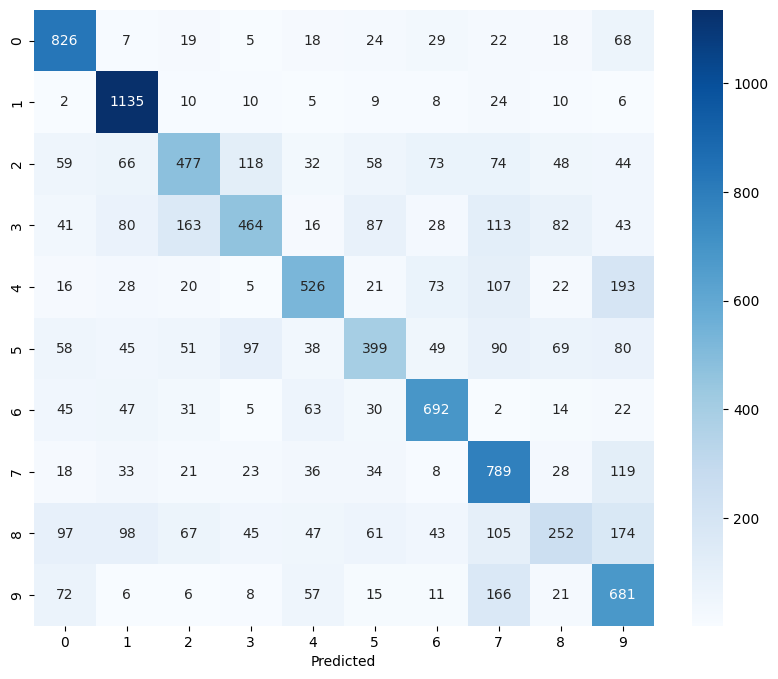

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')

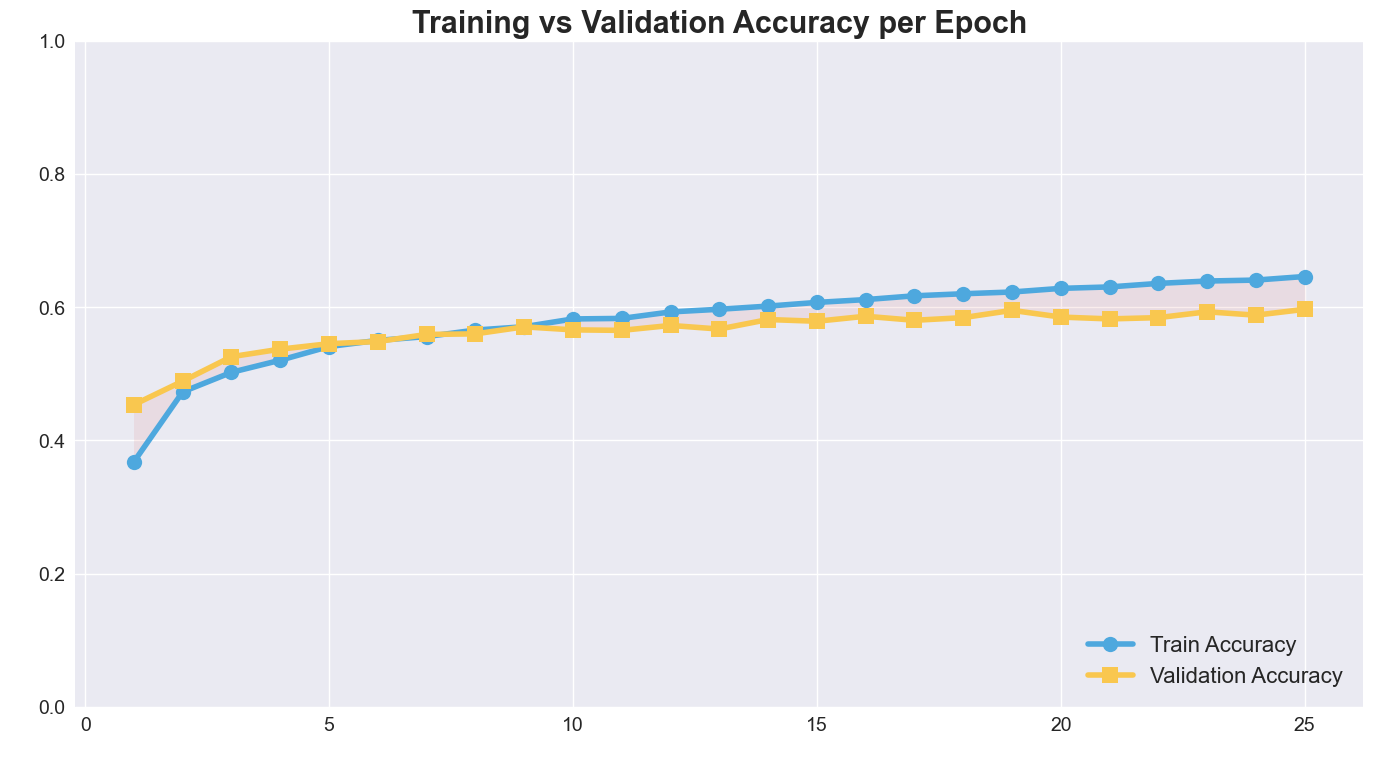

In [24]:
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

epochs = range(1, len(overall_train_acc) + 1)

plt.plot(epochs, overall_train_acc, label='Train Accuracy', linewidth=4, marker='o', color='#4ea8de', markersize=11)
plt.plot(epochs, overall_val_acc, label='Validation Accuracy', linewidth=4, marker='s', color='#f9c74f', markersize=11)

# Highlight the area between curves for clarity
plt.fill_between(epochs, overall_train_acc, overall_val_acc, color="#e08888", alpha=0.15)

plt.xlabel('Epoch', fontsize=18, color='white', weight='bold')
plt.ylabel('Accuracy', fontsize=18, color='white', weight='bold')
plt.title('Training vs Validation Accuracy per Epoch', fontsize=22, weight='bold')
plt.legend(loc='lower right', fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()